In [2]:
import rlcard
from rlcard.agents import RandomAgent
from rlcard.games.base import Card
import torch
from IPython.display import clear_output
from rlcard.utils import reorganize, print_card

In [3]:
env = rlcard.make(
    'limit-holdem-collaborative',
    config={
        'seed': 42,
        'game_num_players': 3
    }
)
# agent1, agent2, agent3 = RandomAgent(num_actions=4), RandomAgent(num_actions=4), RandomAgent(num_actions=4)
agent1 = torch.load('./checkpoint_collab/collab_brain2_more_info.pth')
agent2 = torch.load('./checkpoint_collab/collab_brain2_more_info.pth')
agent3 = torch.load('./checkpoint_comp_65k/comp_brain1_65k.pth')

# brain1 = torch.load('./checkpoint_collab/collab_brain2_more_info.pth')
# brain2 = torch.load('./checkpoint_collab/collab_brain2_more_info.pth')

env.set_agents([agent1, agent2, agent3])
agents = env.agents



In [4]:

game = env.game.init_game()

old_hands = [env.game.players[i].hand for i in range(env.num_players)]

cards = ['C7', 'H2', 'SA', 'HA', 'D8', 'S2']

env.game.players[0].hand = [Card('C', '7'), Card('H', '2')]
env.game.players[1].hand = [Card('S', 'A'), Card('H', 'A')]
env.game.players[2].hand = [Card('D', '8'), Card('S', '2')]

for h in old_hands:
  if str(h[0]) not in cards:
    env.game.dealer.deck.append(h[0])
  if str(h[0]) not in cards:
    env.game.dealer.deck.append(h[1])

trajectories = [[] for _ in range(env.num_players)]

curr_player_id = env.get_player_id()
curr_state = env.get_state(curr_player_id)

trajectories[curr_player_id].append(curr_state)

while not env.is_over():
  curr_player = agents[curr_player_id]
  curr_action = curr_player.eval_step(curr_state)
  
  trajectories[curr_player_id].append(curr_action)

  curr_state, curr_player_id = env.step(curr_action[0], curr_player.use_raw)


  if not env.game.is_over():
    trajectories[curr_player_id].append(curr_state)

for player_id in range(env.num_players):
  state = env.get_state(player_id)
  trajectories[player_id].append(state)


# Payoffs
payoffs = env.get_payoffs()

trajectories = reorganize(trajectories, payoffs)

In [5]:
# # print(curr_state)
# all_actions = ['call', 'raise', 'fold', 'check']
# all_actions[agent1.eval_step(curr_state)[0]]

In [6]:
# action_record = {0: [], 1: [], 2: []}
# for (k, v) in trajectories[0][0][0]['action_record']:
#     if len(action_record[k]) != 0 and action_record[k][-1] == 'fold':
#         continue
#     action_record[k].append(v)

# action_record

In [7]:
import json 
with open("/home/harsh/Downloads/DeceptiveMultiAgentPoker/src/rlcard-multiagent/rlcard/games/limitholdem_collaborative/card2index.json", 'r') as f:
    card2index = json.load(f)


def suppress_state(state, curr_player_id, players):
    if curr_player_id == 2: #Competitive agent
        return state
    if curr_player_id == 0:
        friend_player = players[1].hand
        

In [7]:
#3 x P x 5
# all_actions = ['call', 'raise', 'fold', 'check']
N = 1000
avg_count_comp = [[0] * N for _ in range(3)]
avg_count_collab = [[0] * N for _ in range(3)]

mega_traj = []

episode = 0
while episode < N:
    trajectories, payoffs = env.run(is_training=False)
    trajectories = reorganize(trajectories, payoffs)

    # trajectories = get_trajectories()
    
    num = [len(t) for t in trajectories]
    if min(num) == 0:
        continue

    

    count_comp = [0] *3
    count_collab = [0] *3
    prev_num_step = [0]*3
    for idx, t in enumerate(trajectories):
        len_sim = 1
        for num_step, step in enumerate(t):
            s, a, r, ns, done = step
            old_action = a
            pred_action_comp = agent3.eval_step(s)[0]
            pred_action_collab = agent2.eval_step(s)[0]

            # if pred_action_collab != pred_action_comp:
            len_sim += 1
            count_comp[idx] += pred_action_comp == old_action
            count_collab[idx] += pred_action_collab == old_action

        count_comp[idx] /= len_sim
        count_collab[idx] /= len_sim
        # prev_num_step[idx] = num_step 
        if episode != 0:
            # avg_count[idx][episode] =  avg_count[idx][episode - 1]*prev_num_step[idx] + count[idx]
            # avg_count[idx][episode] /= (prev_num_step[idx] + len(t))
            avg_count_comp[idx][episode] = avg_count_comp[idx][episode - 1] + count_comp[idx]
            avg_count_collab[idx][episode] = avg_count_collab[idx][episode - 1] + count_collab[idx]
        else:
            avg_count_comp[idx][episode] = count_comp[idx]
            avg_count_collab[idx][episode] = count_collab[idx]

    episode += 1
        

    


In [8]:
import matplotlib.pyplot as plt

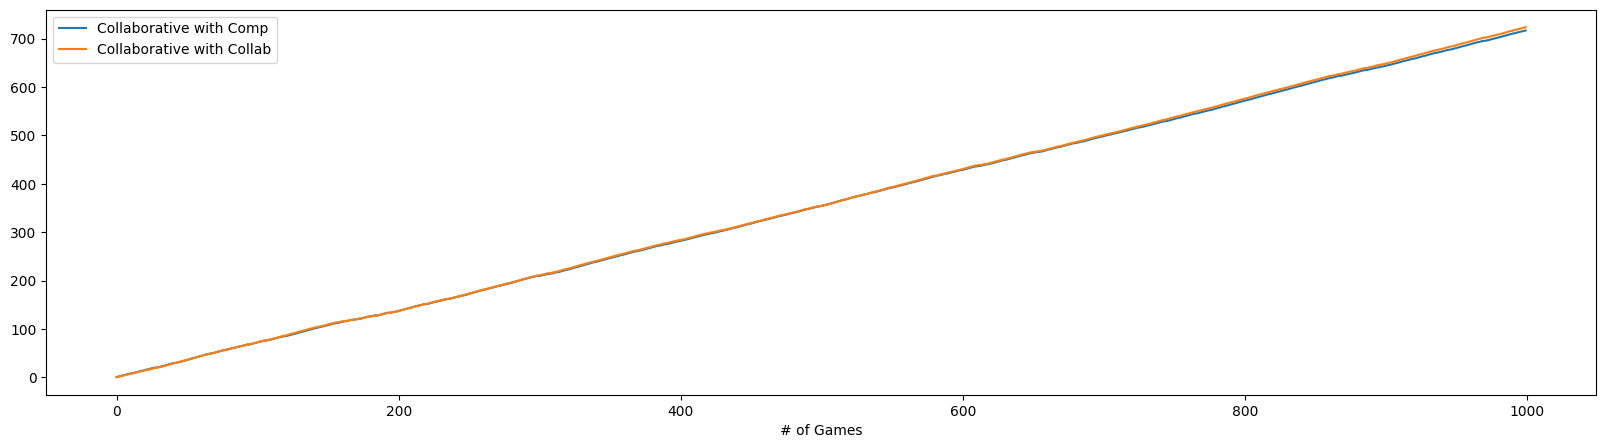

In [9]:
plt.figure(figsize=(20,5))
plt.plot(avg_count_comp[0], label="Collaborative with Comp")
plt.plot(avg_count_collab[0], label="Collaborative with Collab")
# plt.plot(avg_count[1], label="Player2")
# plt.plot(avg_count[2], label="Player3")
plt.xlabel("# of Games")
plt.ylabel("")
plt.legend()

In [71]:
mega_traj = []
for i in range(10000):
    trajectories, payoffs = env.run(is_training=False)
    trajectories = reorganize(trajectories, payoffs)
    mega_traj.append(trajectories)



In [72]:
sa_tuple = [{}, {}]
dummy_state = {}
idx = 0
for trajectory in mega_traj:
    for t in [trajectory[0]]:
        for step in t:
            s, a, r, ns, done = step
            dummy_state[str(s['obs'])] = idx
            sa_tuple[0][idx] = a
            sa_tuple[1][idx] = agent3.eval_step(s)[0]
            idx += 1

In [73]:
dummy_state_keys = list(dummy_state.values())

In [74]:
collab_val = []
comp_val = []
for k in dummy_state_keys:
    collab_val.append(sa_tuple[0][k])
    comp_val.append(sa_tuple[1][k])

/tmp/ipykernel_560406/2370553433.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'call', 'raise', 'fold', 'check', 'sum'])
/tmp/ipykernel_560406/2370553433.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'call', 'raise', 'fold', 'check', 'sum'])


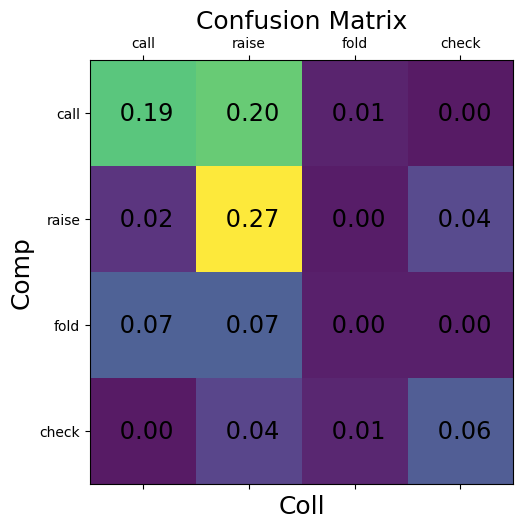

In [106]:
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(comp_val, collab_val)
conf_matrix = np.divide(conf_matrix, np.sum(conf_matrix))
sum_rows = np.sum(conf_matrix, axis=0)
sum_cols = np.sum(conf_matrix, axis=1)
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax.matshow(conf_matrix, cmap='viridis', alpha=0.9)
ax.set_xticklabels(['', 'call', 'raise', 'fold', 'check', 'sum'])
ax.set_yticklabels(['', 'call', 'raise', 'fold', 'check', 'sum'])
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=f'{conf_matrix[i, j]: .2f}', va='center', ha='center', size='xx-large', color="white" if conf_matrix[i][j] < 0.2 else "black")
 
plt.xlabel('Coll', fontsize=18)
plt.ylabel('Comp', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# all_actions = ['call', 'raise', 'fold', 'check']
